# Customer Analytics: Capstone Programming Assignment

<br>

*Austin Koenig*

---

## Table of Contents

---

<a id="toc"></a>

1.1 [Table of Contents](#toc)  
1.2 [Introduction](#intro)  
1.3 [Customer Churn](#churn)  
&nbsp;&nbsp;&nbsp;&nbsp;1.3.1 [Business Problem & Proposed Solution](#churn-prob)  
&nbsp;&nbsp;&nbsp;&nbsp;1.3.2 [Exploratory Analysis](#churn-explore)  
&nbsp;&nbsp;&nbsp;&nbsp;1.3.3 [Model Development](#churn-model)  
&nbsp;&nbsp;&nbsp;&nbsp;1.3.4 [Results & Insights](#churn-results)  
1.4 [Customer Lifetime Value](#clv)  
&nbsp;&nbsp;&nbsp;&nbsp;1.4.1 [Business Problem & Proposed Solution](#clv-prob)  
&nbsp;&nbsp;&nbsp;&nbsp;1.4.2 [Exploratory Analysis](#clv-explore)  
&nbsp;&nbsp;&nbsp;&nbsp;1.4.3 [Model Development](#clv-model)  
&nbsp;&nbsp;&nbsp;&nbsp;1.4.4 [Results & Insights](#clv-results)    
1.5 [References](#refs)


## Introduction

<a id="intro"></a>

---

This project is effectively the combination of three smaller projects dictated by the datasets given to us in the class. For each of the datasets, there will be a corresponding business problem defined in their respective sections, which will thereby be discussed and solutions will be put forth in response. Then, we will conclude with some statements about what we've learned about customers and marketing across these analyses.

To conclude the introduction, we will import the Python libraries which are used in this project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.preprocessing as sklpre
import sklearn.linear_model as sklm

np.random.seed(12)
pd.set_option('display.max_columns', 50)

---

---

## Customer Churn

<a id="churn"></a>

---

Customer churn is generally thought as the likelihood of whether or not a customer will remain a client of a subscription service. It is a simple but important idea for businesses in nearly every industry. Generally, customer churn is associated with the particular data that the company in question has. 

<br>

### Business Problem & Proposed Solution

<a id="churn-prob"></a>

In our case, we have a dataset containing several pieces of data on approximately 7000 customers (including whether or not they've churned) over the course of some time period. Most of the features collected are categorical, encompassing properties such as gender, type of internet service, etc.

In this project, we build a solution that predicts the probability of a customer churning. This probability will act as a metric to determine the degree of interaction the company should administer to the potential churners. Studies have shown that email is one of the most effective ways to engage with customers [1]. This is useful to know since emails are some of the easiest pieces of media to personalize to customers. Thus, we should relate the probability of churn to the type of email that is sent to the customer. Furthermore, there should be some customization to the emails we send to different types of customers. However, catering to the wants and needs of every single customer (of which there are over 7000) is tedious and unnecessary. Instead, we should split them into groups based on the data we have on them. For instance, we could personalize emails by contract duration, whether the customer is a senior, whether they have a partner or dependents, and which particular services they are using. For each of the categorical combinations of these groups, we can split the customers into different *churn categories* that are defined by which interval their probability of churn falls into.<br><br>

> **Churn Categories:**
> 
> - Green: $0\leq p<\pi_-$; Those with the lowest probability of churn
> - Yellow: $\pi_-\leq p<\pi_+$; Those with a moderate probability of churn
> - Red: $\pi_+\leq p<1$; Those with a high probability of churn

The green category consists of loyal customers who are not likely to unsubscribe whereas the red category contains customers who are unhappy or having trouble with the product/service and are therefore very likely to churn. The yellow category encapsulates those who may or may not churn.

There are several definitions of churn [2], but here we will define churn as a rate:

> **Definition 1:** For any time period, $T$, the *churn rate* is the percentage of customers who churn during $T$.

We prefer a rate since it is a lot easier to comprehend at a glance, whereas using simply the number of customers who churn also requires that we know how many customers we have at the beginning of the particular time period.

We should also note that here we are not taking into account the number of customers who we gain each month. A separate dataset on new customers may give us more insight on how to grow our customer base; however, the scope of this project only deals with maintaining the current customer base.

The proposed solution is to apply treatments to customer segments. The segments will be governed by the churn categories defined above. In other words, the goal of this project is to find $\pi_-$ and $\pi_+$ above. This leads to the question of how we will assign a probability of churn for each customer. Using a classification model, we can predict churn using a probability. Then, we can divide the customers into the churn categories which our customer service teams can use to apply different sets of treatments or incentives in order to maintain those customers. If we implement this in the business practice, then we can test whether it's working by examining the previously defined churn rate before and after each treatment cycle.

Now, let's explore the data to see how we can work with it.

<br>

### Exploratory Analysis

<a id="churn-explore"></a>

---

The goal of this section is to understand the data through observation during data preparation and feature selection for a predictive model. First, let's import the data take a look at the first few rows to get an idea of what we're working with.

In [2]:
churn_data_raw = pd.read_csv('./data/Customer_Churn_Dataset.csv')
churn_data_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Here, we have mostly categorical features (that are rather self-explanatory) with more than two possible values. Models generally require data to be at least binary so we will have to prepare the raw data somehow. Below, we go over the steps we take to clean the dataset, which will certainly help us understand the data in more depth.

First, there were a couple of "house-keeping" issues to take care of. We don't need the `customerID` feature since our indices are unique anyway and we are not performing a study outside the scope of these customers. Secondly, one of the numeric features was actually a string, so we simply convert it to a number. Those of the keen eye will notice below that we've exempted a few features from the one-hot encoding. These features are either numeric, already binary, or the actual target feature (`Churn`). Next, we consider briefly one-hot encoding of categorical features.

Algorithms cannot very well interpret strings such as "Electronic check" or "One year", so we need to one-hot encode the data. This means that we convert multi-valued categorical features into a larger number of binary features, which increases the dimensionality of the data substantially. Fortunately, this encoding method allows us to more effectively deal with multicollinearity issues using dimensionality reduction through correlation plots and a brief regression analysis.

In [3]:
churn_data_raw = churn_data_raw.drop('customerID', axis = 1) # drop the customerID column
churn_data_raw['TotalCharges'] = pd.to_numeric(churn_data_raw['TotalCharges'], errors = 'coerce') # str to num

churn_data = pd.DataFrame()
churn_scaler = sklpre.MinMaxScaler()
churn_exempt = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'] # exempt from one-hot encode
    
def churn_encode(feature, label):
    global churn_data
    new_feats = pd.get_dummies(feature, prefix = label, drop_first = True)
    churn_data = pd.concat([churn_data, new_feats], axis = 1)
    
for i in range(len(churn_data_raw.columns)):
    name = churn_data_raw.columns[i]
    if name not in churn_exempt:
        churn_encode(churn_data_raw[name], name)
    
churn_data = pd.concat([churn_data, pd.DataFrame(churn_scaler.fit_transform(churn_data_raw[['tenure', 'MonthlyCharges', 'TotalCharges']]), columns = ['tenure', 'MonthlyCharges', 'TotalCharges'])], axis = 1)
churn_encode(churn_data_raw['Churn'], 'Churn')
churn_data = churn_data.dropna()

In [4]:
churn_data.head()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn_Yes
0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.013889,0.115423,0.001275,0
1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0.472222,0.385075,0.215867,0
2,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.027778,0.354229,0.010310,1
3,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0.625000,0.239303,0.210241,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.027778,0.521891,0.015330,1


In [5]:
churn_corr_base = churn_data.corr()
churn_corr_base.style.background_gradient(cmap = 'RdBu_r', axis = None).set_precision(2)

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges,Churn_Yes
gender_Male,1,-0.0018,-0.0014,0.01,-0.0075,0.0075,-0.0089,-0.011,0.0047,0.0047,-0.016,0.0047,-0.013,0.0047,-0.00081,0.0047,-0.0085,0.0047,-0.0071,0.0047,-0.01,0.0078,-0.0036,-0.012,0.0016,0.00084,0.013,0.0053,-0.014,4.8e-05,-0.0085
SeniorCitizen_1,-0.0018,1,0.017,-0.21,0.0084,-0.0084,0.14,0.25,-0.18,-0.18,-0.039,-0.18,0.067,-0.18,0.06,-0.18,-0.061,-0.18,0.11,-0.18,0.12,-0.046,-0.12,0.16,-0.024,0.17,-0.15,0.016,0.22,0.1,0.15
Partner_Yes,-0.0014,0.017,1,0.45,0.018,-0.018,0.14,0.0012,-0.00029,-0.00029,0.14,-0.00029,0.14,-0.00029,0.15,-0.00029,0.12,-0.00029,0.12,-0.00029,0.12,0.083,0.25,-0.014,0.082,-0.083,-0.097,0.38,0.098,0.32,-0.15
Dependents_Yes,0.01,-0.21,0.45,1,-0.0011,0.0011,-0.024,-0.16,0.14,0.14,0.081,0.14,0.024,0.14,0.014,0.14,0.063,0.14,-0.016,0.14,-0.038,0.069,0.2,-0.11,0.061,-0.15,0.056,0.16,-0.11,0.065,-0.16
PhoneService_Yes,-0.0075,0.0084,0.018,-0.0011,1,-1,0.28,0.29,0.17,0.17,-0.092,0.17,-0.052,0.17,-0.07,0.17,-0.095,0.17,-0.021,0.17,-0.033,-0.0031,0.0044,0.017,-0.0069,0.0027,-0.0045,0.0079,0.25,0.11,0.012
MultipleLines_No phone service,0.0075,-0.0084,-0.018,0.0011,-1,1,-0.28,-0.29,-0.17,-0.17,0.092,-0.17,0.052,-0.17,0.07,-0.17,0.095,-0.17,0.021,-0.17,0.033,0.0031,-0.0044,-0.017,0.0069,-0.0027,0.0045,-0.0079,-0.25,-0.11,-0.012
MultipleLines_Yes,-0.0089,0.14,0.14,-0.024,0.28,-0.28,1,0.37,-0.21,-0.21,0.099,-0.21,0.2,-0.21,0.2,-0.21,0.1,-0.21,0.26,-0.21,0.26,-0.0036,0.11,0.16,0.06,0.084,-0.23,0.33,0.49,0.47,0.04
InternetService_Fiber optic,-0.011,0.25,0.0012,-0.16,0.29,-0.29,0.37,1,-0.47,-0.47,-0.031,-0.47,0.17,-0.47,0.18,-0.47,-0.02,-0.47,0.33,-0.47,0.32,-0.077,-0.21,0.33,-0.051,0.34,-0.31,0.018,0.79,0.36,0.31
InternetService_No,0.0047,-0.18,-0.00029,0.14,0.17,-0.17,-0.21,-0.47,1,1,-0.33,1,-0.38,1,-0.38,1,-0.34,1,-0.41,1,-0.42,0.038,0.22,-0.32,0.0019,-0.28,0.32,-0.038,-0.76,-0.37,-0.23
OnlineSecurity_No internet service,0.0047,-0.18,-0.00029,0.14,0.17,-0.17,-0.21,-0.47,1,1,-0.33,1,-0.38,1,-0.38,1,-0.34,1,-0.41,1,-0.42,0.038,0.22,-0.32,0.0019,-0.28,0.32,-0.038,-0.76,-0.37,-0.23


This correlation matrix verifies that while there are some features which correlate with churn, there is a great deal of multicollinearity. This means that many of the features are all related with each other just as they are related to churn. One way to combat this and reduce dimensionality simultaneously is to perform a regression analysis to select only the most predictive features of churn.

In [6]:
Xch = churn_data.drop('Churn_Yes', axis = 1)
Xch = pd.DataFrame(sm.add_constant(Xch))
ych = churn_data['Churn_Yes']
churn_feature_filter = sm.OLS(ych, Xch)
churn_feature_filter_fit = churn_feature_filter.fit()

d:\python 3.7\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Let's now take a look at the summary of our feature filter regression analysis as well as a list of the features we've found to be the most indicative of churn.

In [7]:
churn_feature_filter_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Churn_Yes   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     120.6
Date:                Fri, 06 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:35:28   Log-Likelihood:                -3059.9
No. Observations:                7032   AIC:                             6168.
Df Residuals:                    7008   BIC:                             6332.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                 -1.426e+12   9.83e+11     -1.450      0.147   -3.35e+12    5.01e+11
gender_Male                              -0.0035      0.009     -0.391      0.696      -0.021       0.014
SeniorCitizen_1                           0.0438      0.013      3.367      0.001       0.018       0.069
Partner_Yes                              -0.0011      0.011     -0.101      0.920      -0.022       0.020
Dependents_Yes                           -0.0205      0.011     -1.784      0.074      -0.043       0.002
PhoneService_Yes                       1.426e+12   9.83e+11      1.450      0.147   -5.01e+11    3.35e+12
MultipleLines_No phone service         1.426e+12   9.83e+11      1.450      0.147   -5.01e+11    3.35e+12
MultipleLines_Yes                         0.0584      0.024      2.393      0.017       0.011       0.106
InternetService_Fiber optic               0.2097      0.110      1.913      0.056      -0.005       0.425
InternetService_No                       -0.0285      0.016     -1.785      0.074      -0.060       0.003
OnlineSecurity_No internet service       -0.0239      0.016     -1.503      0.133      -0.055       0.007
OnlineSecurity_Yes                       -0.0428      0.025     -1.720      0.085      -0.092       0.006
OnlineBackup_No internet service         -0.0239      0.016     -1.503      0.133      -0.055       0.007
OnlineBackup_Yes                         -0.0110      0.024     -0.450      0.653      -0.059       0.037
DeviceProtection_No internet service     -0.0277      0.016     -1.744      0.081      -0.059       0.003
DeviceProtection_Yes                      0.0043      0.025      0.174      0.862      -0.044       0.053
TechSupport_No internet service          -0.0251      0.016     -1.584      0.113      -0.056       0.006
TechSupport_Yes                          -0.0443      0.025     -1.767      0.077      -0.093       0.005
StreamingTV_No internet service          -0.0252      0.016     -1.589      0.112      -0.056       0.006
StreamingTV_Yes                           0.0634      0.045      1.408      0.159      -0.025       0.152
StreamingMovies_No internet service      -0.0245      0.016     -1.548      0.122      -0.056       0.007
StreamingMovies_Yes                       0.0655      0.045      1.454      0.146      -0.023       0.154
Contract_One year                        -0.1055      0.014     -7.539      0.000      -0.133      -0.078
Contract_Two year                        -0.0698      0.017     -4.093      0.000      -0.103      -0.036
PaperlessBilling_Yes                      0.0449      0.010      4.491      0.000       0.025       0.064
PaymentMethod_Credit card (automatic)    -0.0056      0.014     -0.412      0.680      -0.032       0.021
PaymentMe

We see immediately that these features are predictive of churn by looking at the F-statistic and it's p-value. The F-statistic is large and the p-value is small, which is indicative of predictability in the model. Furthermore, it seems that the t-statistics of several of the features are large enough to produce a p-value far less than 0.05. These are likely the most useful features in predicting churn, but it is difficult to be sure since there is a rather large amount of multicollinearity present in the data. This does not affect the power of predictability as much as it hides from us the features which truly matter in the customer's decision to churn. Regardless, below is a list of the features that the regression analysis has indicated are most useful in predicting churn.

In [8]:
churn_pvals = churn_feature_filter_fit.pvalues
churn_useful_features = list(churn_pvals[churn_pvals < 0.05].index)

if 'const' in churn_useful_features:
    churn_useful_features.remove('const')

for f in churn_useful_features:
    print(f)

SeniorCitizen_1
MultipleLines_Yes
Contract_One year
Contract_Two year
PaperlessBilling_Yes
PaymentMethod_Electronic check
tenure
TotalCharges


In [9]:
churn_corr = churn_data[churn_useful_features].corr()
churn_corr.style.background_gradient(cmap = 'RdBu_r', axis = None).set_precision(2)

,SeniorCitizen_1,MultipleLines_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Electronic check,tenure,TotalCharges
SeniorCitizen_1,1,0.14,-0.046,-0.12,0.16,0.17,0.016,0.1
MultipleLines_Yes,0.14,1,-0.0036,0.11,0.16,0.084,0.33,0.47
Contract_One year,-0.046,-0.0036,1,-0.29,-0.052,-0.11,0.2,0.17
Contract_Two year,-0.12,0.11,-0.29,1,-0.15,-0.28,0.56,0.36
PaperlessBilling_Yes,0.16,0.16,-0.052,-0.15,1,0.21,0.0048,0.16
PaymentMethod_Electronic check,0.17,0.084,-0.11,-0.28,0.21,1,-0.21,-0.06
tenure,0.016,0.33,0.2,0.56,0.0048,-0.21,1,0.83
TotalCharges,0.1,0.47,0.17,0.36,0.16,-0.06,0.83,1


As described above, even between the "most predictive features", we still see a great amount of multicollinearity. Most of these instances are intrinsically rooted in their origin. For example, the features `tenure` and `TotalCharges` are related in that if a customer has a longer tenure, she will have naturally paid more during her subscription. Another example lies in the fact that many of these features are phone-related. Consider also that the features `MultipleLines_No phone service` and `MultipleLines_Yes` both originate from the same feature in the encoding process, which certainly implies a close relationship. 

However, even data with severe multicollinearity is useful if the only purpose of the model is to make predictions [3], which is the goal of this solution. Since we cannot draw any certain conclusions of the best predictors of churn, we will use all of the features and rely on the final model to perform despite the multicollinearity.

Finally, before we move on to model development, let's take a look at the output distribution, which will tell us about the churn rate as well as whether there are problems with homogeneity in the data.

0.26578498293515357


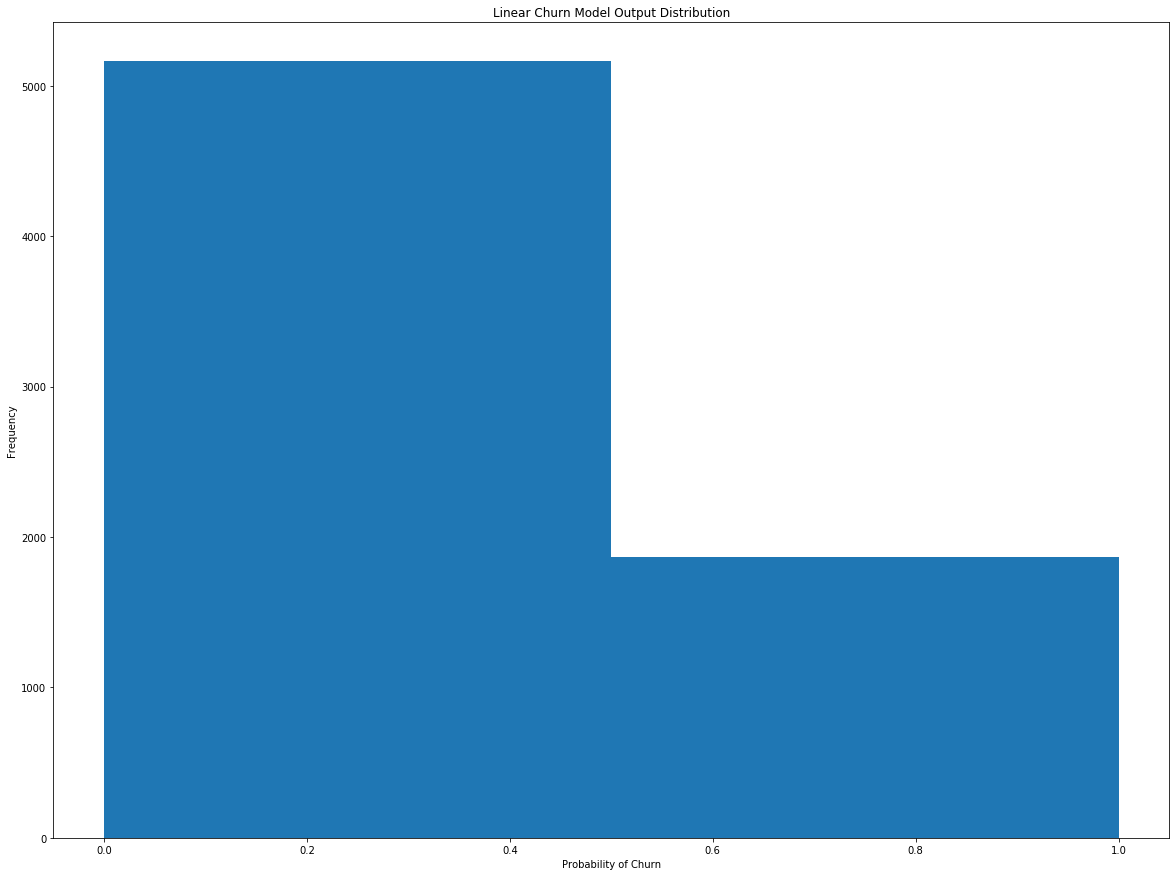

In [10]:
churn_dist_figure = plt.figure(figsize = (20, 15))
churn_dist_axis = churn_dist_figure.add_subplot(111)
churn_dist_axis.hist(churn_data['Churn_Yes'], bins = 2)
churn_dist_axis.title.set_text('Linear Churn Model Output Distribution')
churn_dist_axis.set_xlabel('Probability of Churn')
churn_dist_axis.set_ylabel('Frequency')

print(np.sum(churn_data['Churn_Yes']) / churn_data.shape[0])

We see that for the current time period, there was an approximate 26.58% churn rate. While this is good news for the company that they are retaining about three quarters of their customer base, it is bad news in that it may cause some homogeneity issues, but this case is not very severe. Thus, it may be possible that no alternative sampling techniques are necessary. Therefore, this will be considered for further studies on churn. Finally, let's create our model.

### Model Development

Clearly, we need to use a classification model. However, there are many different models to pick from. For this project, after a great amount of experimentation, it was found that a simple linear regression model was the most efficient, meaning that it delivered the best results for the number of parameters. For instance, we only beat the accuracy of the simple model by less than 1% when we tested a neural network with several layers, each containing several hundred neurons. It is not worth taking the computation time to train the more complicated model when a simple one delivers results that are nearly as good. Below shows the process of creating and testing the linear model.

Those of a keen eye might stop and suggest to use a logistic regression model instead. The reason we don't use a logistic regression model is that the data produced a singular matrix, meaning that it can't be inverted to compute the parameters. An ordinary least squares regression uses the *pseudo inverse*, which can be thought of as an approximate inverse. In this case, the pseudo inverse succeeds where the true inverse is not available. It can be speculated that the matrix singularity was caused by the multicollinearity between the features discovered above. However, even severe multicollinearity doesn't hinder predictive power so we will continue with the linear regression model.

Here, we split the data into training and testing sets to display the performance of the model.

In [11]:
split = 0.7
split_index = int(split * churn_data.shape[0])

Xch_train = churn_data.drop('Churn_Yes', axis = 1).iloc[:split_index, :]
ych_train = churn_data['Churn_Yes'].iloc[:split_index]

Xch_test = churn_data.drop('Churn_Yes', axis = 1).iloc[split_index:, :]
ych_test = churn_data['Churn_Yes'].iloc[split_index:]

print(Xch_train.shape, ych_train.shape)
print(Xch_test.shape, ych_test.shape)

(4922, 30) (4922,)
(2110, 30) (2110,)


In [12]:
churn_model = sklm.LinearRegression()
churn_model.fit(Xch_train, ych_train)

churn_predicted = churn_model.predict(Xch_test)
churn_crate = np.count_nonzero(np.around(churn_predicted) == ych_test)

print("Correct Classification Rate: ", churn_crate / len(ych_test))

Correct Classification Rate:  0.7924170616113744


Certainly, an 80% success rate is good news, especially from a simple linear regression model. Let's take a look at the distribution of outputs.

Text(0, 0.5, 'Frequency')

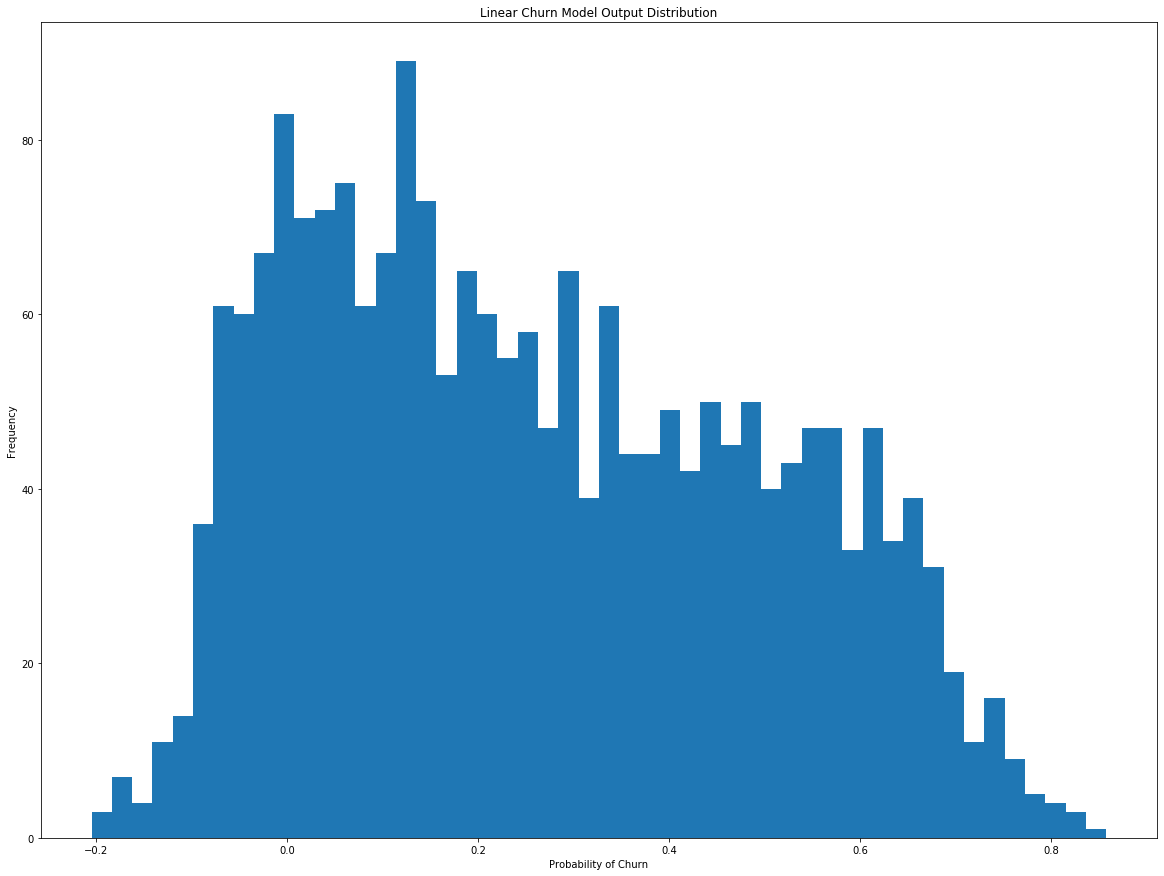

In [13]:
churn_lm_dist_figure = plt.figure(figsize = (20, 15))
churn_lm_dist_axis = churn_lm_dist_figure.add_subplot(111)
churn_lm_dist_axis.hist(churn_predicted, bins = 50)
churn_lm_dist_axis.title.set_text('Linear Churn Model Output Distribution')
churn_lm_dist_axis.set_xlabel('Probability of Churn')
churn_lm_dist_axis.set_ylabel('Frequency')

In [14]:
churn_categories = pd.qcut(churn_predicted, 3)
churn_category_totals = churn_categories.value_counts()
print(churn_category_totals)

(-0.206, 0.115]    704
(0.115, 0.371]     705
(0.371, 0.857]     701
dtype: int64


| Category | Count |
| --- | --- |
| Green | 704 |
| Yellow | 705 |
| Red | 701 |

Above are the three categories which were determined from the model. We see that $\pi_-=0.115$ and $\pi_+=0.371$ for the proportions listed above.

We want a roughly equal number of customers in each category so that we don't overwhelm any one particular customer service team. Therefore, the actual intervals will change over time so long that we only want three categories. This method is flexible to any number of categories: this project only entertains three of them since it is an intuitive number representing a low, medium, and high level of churn.

While these are all well-and-good, we really want to see how our results match with the output probability from the data. So, let's see a histogram with these probability results squeezed into a classification.

0.2


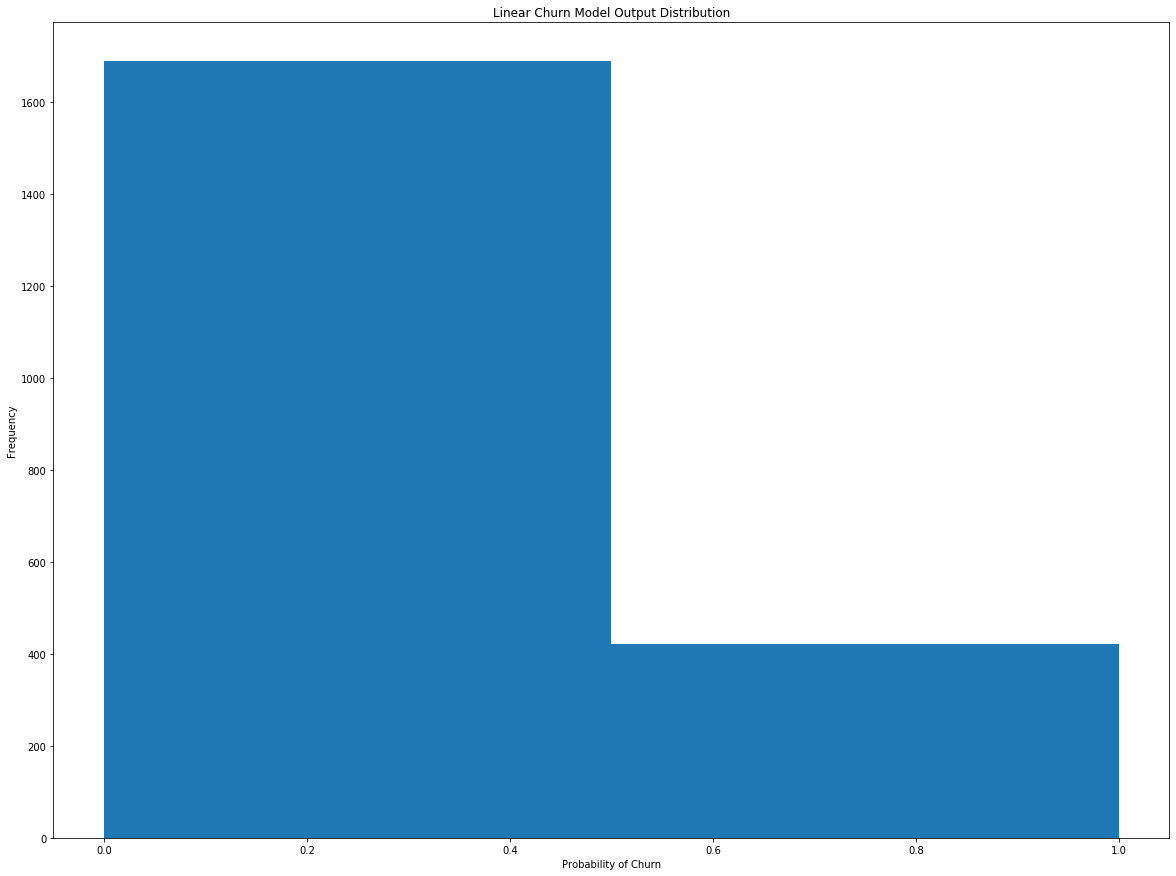

In [15]:
churn_lm_dist_class_figure = plt.figure(figsize = (20, 15))
churn_lm_dist_class_axis = churn_lm_dist_class_figure.add_subplot(111)
churn_lm_dist_class_axis.hist(np.around(churn_predicted), bins = 2)
churn_lm_dist_class_axis.title.set_text('Linear Churn Model Output Distribution')
churn_lm_dist_class_axis.set_xlabel('Probability of Churn')
churn_lm_dist_class_axis.set_ylabel('Frequency')

print(np.sum(np.around(churn_predicted)) / churn_predicted.shape[0])

Our model has produced a result very close to the original data. However, we notice that the probability distribution of the model output appears bimodal, which indicates that it does not satisfy all assumptions of a linear model. However, as described above, more complicated models not relying on the same assumptions only improved the accuracy by less than a percent. For this reason along with the fact that the original problem is a classification problem (not a regression problem), we will deliberately overlook this issue.

One final observation is that there are negative probabilities. These don't make sense mathematically (for the reason just described), but recall that we're using a regressor to mimick a classifier. Thus, this negative probability of churn is so low that it might be representative of a positive probability of retention. The company may not even need to worry about these customers because they are so happy with the product/service.

### Results & Insights

Now, the 700+ customers in each category can be treated accordingly:

- those with high probability of churn are treated with incentives to remain customers
- those with medium probability of churn are treated with appreciative treatments which are less sever than the incentives used on high probability churners
- those with low probability are not treated since they are most likely to stay customers without any intervention

With this model, new customers can be automatically brought to the attention of the appropriate customer service team. The churn rate can be monitored over time to determine whether the treatments being used by the customer service teams are working. Furthermore, we can study the effects of using more churn categories: perhaps we can look through the multicollinearity in the input to see the different reasons why people are churning, thus giving a way to segment customers not based on a simple probability.

In a further study, we should consider in more depth the issues behind the multicollinearity in this dataset. While it is useful to predict the probability of customer churn, it would be more useful to know the causes of churn. These causes are in this dataset, but the fact that they are so interrelated shields the true nature of churn. Thus, a deeper study into the specific instances of multicollinearity should be conducted in order to alleviate the interdependence of input features for our model. Furthermore, this would reveal which features are actually associated with churn so that our company can take a more proactive approact to churn.

---

---


## Customer Lifetime Value

---

<a id="clv"></a>

These data come from the `Marketing_Customer_Value_Analysis.csv` dataset. Upon a first glance, it seems to be customer data from an automotive insurance company. The target feature in this dataset is `Customer Lifetime Value`, a discussion of which follows.

Customer lifetime value (CLV) is a time-dependent measure of how valuable a customer is to a particular company or service. Formally, we resort to the following definition:

> **Definition 2:** For any time customer over some number of time periods, $T$, the *net customer lifetime value*, $V$, is computed as follows:
>
> $$V = -C_0 + \sum_{i=1}^{T} C_i \big( \frac{1}{1 + r} \big)^i$$,
> 
> where $C_i$ is the $i^{th}$ investment and $r$ is known as the *discount rate*. Furthermore, the sequence $\{C_i\}_{i=0}^{T}$ is known as the *cash flow*.

The data already contains this value, which is helpful since we can use the data to identify similar customers to those with large CLV.

### Business Problem & Proposed Solution

<a id="clv-prob"></a>

Since the data comes from an insurance company, there is a lot of demographic data which is generally used to calculate risk. However, we wish to use this data to grow our customer base in a data-driven way.

We propose a situation in which we want to advertise our insurance. However, advertisements are expensive, so we should prioritize the customers we should target. As it turns out, we have customer demographic data as well as their CLV. We wish to decide which demographics to target that yield the greatest and the least customer value. 

The solution below is a generalized linear model, which is similar to a linear regression model except that it assumes a different distribution of the output.

### Exploratory Analysis

<a id="clv-explore"></a>

Let's take a look at the features we have on each customer.

In [16]:
clv_data_raw = pd.read_csv('./data/Marketing_Customer_Value_Analysis.csv')
clv_data_raw.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


It seems we are working with a lot of multi-valued categorical features. Let's take a look at these features to examine just what values we have here.

In [17]:
print(f"Shape of Dataset: {clv_data_raw.shape}")

for i in range(len(clv_data_raw.columns)):
    if not np.issubdtype(clv_data_raw[clv_data_raw.columns[i]].dtype, np.number):
        print(clv_data_raw.columns[i], clv_data_raw[clv_data_raw.columns[i]].unique())

Shape of Dataset: (9134, 24)
Customer ['BU79786' 'QZ44356' 'AI49188' ... 'TD14365' 'UP19263' 'Y167826']
State ['Washington' 'Arizona' 'Nevada' 'California' 'Oregon']
Response ['No' 'Yes']
Coverage ['Basic' 'Extended' 'Premium']
Education ['Bachelor' 'College' 'Master' 'High School or Below' 'Doctor']
Effective To Date ['2/24/11' '1/31/11' '2/19/11' '1/20/11' '2/3/11' '1/25/11' '1/18/11'
 '1/26/11' '2/17/11' '2/21/11' '1/6/11' '2/6/11' '1/10/11' '1/17/11'
 '1/5/11' '2/27/11' '1/14/11' '1/21/11' '2/5/11' '1/29/11' '2/28/11'
 '2/12/11' '2/2/11' '2/7/11' '1/22/11' '2/13/11' '1/15/11' '1/8/11'
 '1/11/11' '1/28/11' '2/8/11' '2/23/11' '1/2/11' '2/16/11' '1/27/11'
 '1/23/11' '1/9/11' '2/11/11' '2/4/11' '2/1/11' '2/15/11' '2/26/11'
 '1/16/11' '1/1/11' '2/10/11' '1/24/11' '2/25/11' '1/12/11' '2/9/11'
 '1/19/11' '1/4/11' '2/14/11' '2/20/11' '2/18/11' '1/3/11' '1/13/11'
 '1/30/11' '2/22/11' '1/7/11']
EmploymentStatus ['Employed' 'Unemployed' 'Medical Leave' 'Disabled' 'Retired']
Gender ['F' 'M']
L

These features are useful because they will tell us, for instance, whether we should spend more to advertise to those with a Bachelors degree or a Masters degree. However, these features are numerous and are not all indicative of CLV. Thus, we now need to clean the data and figure out which features are actually useful to our purpose.

We will here one-hot encode the categorical features and scale the numerical features. For this project, we will simply drop the `Effective To Date` feature.

In [18]:
clv_data_raw = clv_data_raw.drop('Customer', axis = 1) # drop the Customer column
clv_data_raw = clv_data_raw.drop('Effective To Date', axis = 1) # drop the Effective To Date column

clv_data = pd.DataFrame()
clv_scaler = sklpre.MinMaxScaler()
clv_exempt = ['Income', 
              'Monthly Premium Auto', 
              'Months Since Last Claim',
              'Months Since Policy Inception',
              'Number of Open Complaints',
              'Number of Policies',
              'Total Claim Amount',
              'Customer Lifetime Value'] # exempt from one-hot encode
    
def clv_encode(feature, label):
    global clv_data
    new_feats = pd.get_dummies(feature, prefix = label, drop_first = True)
    clv_data = pd.concat([clv_data, new_feats], axis = 1)
    
for i in range(len(clv_data_raw.columns)):
    name = clv_data_raw.columns[i]
    if name not in clv_exempt:
        clv_encode(clv_data_raw[name], name)
    
clv_data = pd.concat([clv_data, pd.DataFrame(clv_scaler.fit_transform(clv_data_raw[clv_exempt]), columns = clv_exempt)], axis = 1)
clv_data = clv_data.dropna()
print(f"New Dataset Shape: {clv_data.shape}")
clv_data.head()

New Dataset Shape: (9134, 51)


,State_California,State_Nevada,State_Oregon,State_Washington,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Gender_M,Location Code_Suburban,Location Code_Urban,Marital Status_Married,Marital Status_Single,Policy Type_Personal Auto,Policy Type_Special Auto,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,...,Policy_Personal L3,Policy_Special L1,Policy_Special L2,Policy_Special L3,Renew Offer Type_Offer2,Renew Offer Type_Offer3,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Customer Lifetime Value
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.562847,0.033755,0.914286,0.050505,0.0,0.000,0.132974,0.010629
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.000000,0.139241,0.371429,0.424242,0.0,0.875,0.391051,0.062406
2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.487763,0.198312,0.514286,0.383838,0.0,0.125,0.195764,0.134960
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0.000000,0.189873,0.514286,0.656566,0.0,0.750,0.183117,0.070589
4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.438443,0.050633,0.342857,0.444444,0.0,0.000,0.047710,0.011245


Note here that we haven't dropped any rows due to null values. What incredible data cleanliness this company exercises! This leaves a lot of data to use for our problem. Similar to the above problem, we should first look at the output distribution as well as a correlation matrix of the data.

Text(0, 0.5, 'Frequency')

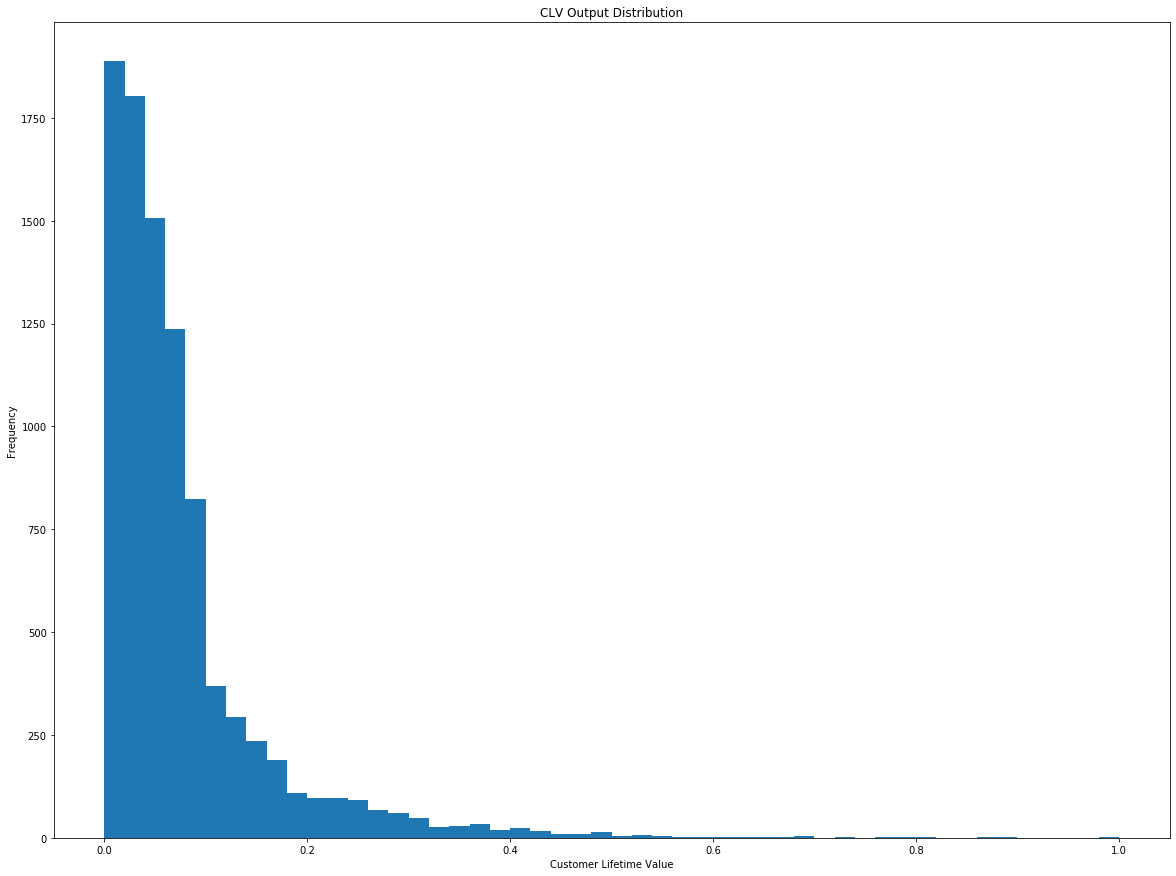

In [19]:
clv_dist_figure = plt.figure(figsize = (20, 15))
clv_dist_axis = clv_dist_figure.add_subplot(111)
clv_dist_axis.hist(clv_data['Customer Lifetime Value'], bins = 50)
clv_dist_axis.title.set_text('CLV Output Distribution')
clv_dist_axis.set_xlabel('Customer Lifetime Value')
clv_dist_axis.set_ylabel('Frequency')

In [20]:
clv_corr_base = clv_data.corr()
clv_corr_base.style.background_gradient(cmap = 'RdBu_r', axis = None).set_precision(2)

The target feature is not normally distributed, implying that an ordinary linear regression (OLS) model will not suffice. We instead need to use a generalized linear model (GLM) so that we may specify the assumed output distribution. There doesn't seem to be very much correlation between each of the input features, but there are several features that correlate with the CLV feature. Let's now move on to a regression analysis to determine the best features to use.

### Model Development

<a id="clv-model"></a>

Regression analysis can tell us a lot about the effectiveness of features in predicting the target feature through t-tests and the corresponding p-values. However, we know from the distribution plot above that our target feature looks far from normal. Thus, we will instead use a generalized linear model with a Tweedie distribution assumed to be the output distribution. Let us now create this feature selection model.

In [21]:
Xclv = clv_data.drop('Customer Lifetime Value', axis = 1)
Xclv = pd.DataFrame(sm.add_constant(Xclv))
yclv = clv_data['Customer Lifetime Value']
clv_feature_filter = sm.GLM(yclv, Xclv, family = sm.families.Tweedie())
clv_feature_filter_fit = clv_feature_filter.fit()
clv_feature_filter_fit.summary()

d:\python 3.7\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
d:\python 3.7\lib\site-packages\statsmodels\genmod\families\family.py:1440: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
d:\python 3.7\lib\site-packages\statsmodels\genmod\families\family.py:1440: RuntimeWarning: invalid value encountered in multiply
  endog * np.log(endog / mu) + (mu - endog))


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     Customer Lifetime Value   No. Observations:                 9134
Model:                                 GLM   Df Residuals:                     9085
Model Family:                      Tweedie   Df Model:                           48
Link Function:                         log   Scale:                        0.073327
Method:                               IRLS   Log-Likelihood:                    nan
Date:                     Fri, 06 Dec 2019   Deviance:                       491.80
Time:                             18:35:33   Pearson chi2:                     666.
No. Iterations:                         95                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -2.9647      0.097    -30.642      0.000      -3.154      -2.775
State_California                   0.0118      0.030      0.392      0.695      -0.047       0.071
State_Nevada                       0.0158      0.041      0.382      0.702      -0.065       0.097
State_Oregon                       0.0178      0.031      0.574      0.566      -0.043       0.079
State_Washington                   0.0249      0.043      0.584      0.559      -0.059       0.109
Response_Yes                      -0.0433      0.033     -1.310      0.190      -0.108       0.022
Coverage_Extended                  0.1648      0.035      4.704      0.000       0.096       0.234
Coverage_Premium                   0.2627      0.073      3.588      0.000       0.119       0.406
Education_College                  0.0039      0.027      0.142      0.887      -0.050       0.057
Education_Doctor                  -0.0378      0.059     -0.637      0.524      -0.154       0.079
Education_High School or Below     0.0651      0.027      2.397      0.017       0.012       0.118
Education_Master                   0.0325      0.041      0.794      0.427      -0.048       0.113
EmploymentStatus_Employed          0.1128      0.056      2.004      0.045       0.002       0.223
EmploymentStatus_Medical Leave     0.0401      0.070      0.571      0.568      -0.098       0.178
EmploymentStatus_Retired          -0.0018      0.082     -0.022      0.982      -0.162       0.158
EmploymentStatus_Unemployed        0.0013      0.057      0.023      0.981      -0.111       0.113
Gender_M                          -0.0217      0.021     -1.036      0.300      -0.063       0.019
Location Code_Suburban            -0.0309      0.041     -0.758      0.449      -0.111       0.049
Location Code_Urban                0.0070      0.038      0.185      0.853      -0.067       0.081
Marital Status_Married            -0.0278      0.030     -0.918      0.359      -0.087       0.032
Marital Status_Single             -0.0812      0.036     -2.280      0.023      -0.151      -0.011
Policy Type_Personal Auto         -0.0464      0.039     -1.189      0.234      -0.123       0.030
Policy Type_Special Auto           0.0235      0.055      0.427      0.669      -0.084       0.131
Policy_Corporate L2               -0.1607      0.066     -2.447      0.014      -0.289      -0.032
Policy_Corporate L3               -0.1057      0.060     -1.773      0.076      -0.223       0.011
Policy_Personal L1                -0.0238      0.026     -0.932      0.351      -0.074       0.026
Policy_Personal L2                 0.0016      0.022      0.072      0.943      -0.042       0.045
Policy_Personal L3                -0.0242      0.020     -

In [22]:
clv_pvals = clv_feature_filter_fit.pvalues
clv_useful_features = clv_pvals[clv_pvals < 0.05]

#if 'const' in clv_useful_features:
#    clv_useful_features.remove('const')

print(clv_useful_features.sort_values())

const                             3.338866e-206
Vehicle Class_SUV                  3.749414e-11
Vehicle Class_Sports Car           6.625729e-10
Renew Offer Type_Offer2            1.594602e-09
Renew Offer Type_Offer4            8.236166e-08
Coverage_Extended                  2.553844e-06
Number of Open Complaints          1.222341e-04
Coverage_Premium                   3.337599e-04
Monthly Premium Auto               1.161719e-03
Vehicle Class_Luxury SUV           1.274720e-03
Vehicle Class_Luxury Car           1.323369e-03
Renew Offer Type_Offer3            6.378195e-03
Policy_Corporate L2                1.441070e-02
Education_High School or Below     1.653494e-02
Number of Policies                 1.749041e-02
Marital Status_Single              2.259687e-02
EmploymentStatus_Employed          4.511258e-02
dtype: float64


Alas, we have a list of the most predictive features of CLV. Excluding the features relating to specific insurance plans, it leaves employment status, marital status, vehicle class, state, gender, and a measure of education. Let's create a more specific model to gain a better idea of these features. We will use the features derived from the following in this next model:

- `Education`
- `EmploymentStatus`
- `Marital Status`
- `Vehicle Class`

Note that we are not going to use `State` or `Gender` to avoid location and gender bias, which shouldn't be important in the realm of insurance.

In [23]:
desired_features = ['Education_Doctor', 'Education_Master', 'Education_College', 'Education_High School or Below',
                   'EmploymentStatus_Employed', 'EmploymentStatus_Unemployed', 'EmploymentStatus_Medical Leave', 'EmploymentStatus_Retired',
                   'Marital Status_Married', 'Marital Status_Single',
                   'Vehicle Class_SUV', 'Vehicle Class_Sports Car', 'Vehicle Class_Luxury Car', 'Vehicle Class_Luxury SUV']
Xclv_spec = clv_data[desired_features]
Xclv_spec = pd.DataFrame(sm.add_constant(Xclv_spec))
yclv_spec = clv_data['Customer Lifetime Value']
clv_spec_feature_filter = sm.GLM(yclv_spec, Xclv_spec, family = sm.families.Gamma())
clv_spec_feature_filter_fit = clv_spec_feature_filter.fit()
clv_spec_feature_filter_fit.summary()

d:\python 3.7\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)
d:\python 3.7\lib\site-packages\statsmodels\genmod\families\family.py:735: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                    
===================================================================================
Dep. Variable:     Customer Lifetime Value   No. Observations:                 9134
Model:                                 GLM   Df Residuals:                     9119
Model Family:                        Gamma   Df Model:                           14
Link Function:               inverse_power   Scale:                          1.0841
Method:                               IRLS   Log-Likelihood:                    inf
Date:                     Fri, 06 Dec 2019   Deviance:                       8061.3
Time:                             18:35:33   Pearson chi2:                 9.89e+03
No. Iterations:                          8                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             17.3058      0.771     22.443      0.000      15.794      18.817
Education_Doctor                   0.6096      0.815      0.748      0.454      -0.987       2.206
Education_Master                  -0.3185      0.519     -0.614      0.539      -1.335       0.698
Education_College                  0.0783      0.359      0.218      0.827      -0.626       0.783
Education_High School or Below    -0.6219      0.347     -1.792      0.073      -1.302       0.058
EmploymentStatus_Employed         -0.9638      0.685     -1.408      0.159      -2.305       0.378
EmploymentStatus_Unemployed        0.1590      0.740      0.215      0.830      -1.292       1.610
EmploymentStatus_Medical Leave    -0.2299      0.945     -0.243      0.808      -2.083       1.623
EmploymentStatus_Retired           0.6825      1.090      0.626      0.531      -1.454       2.819
Marital Status_Married             0.5679      0.377      1.505      0.132      -0.171       1.307
Marital Status_Single              1.0088      0.453      2.229      0.026       0.122       1.896
Vehicle Class_SUV                 -7.6403      0.322    -23.725      0.000      -8.272      -7.009
Vehicle Class_Sports Car          -7.9632      0.488    -16.314      0.000      -8.920      -7.006
Vehicle Class_Luxury Car         -11.7267      0.491    -23.889      0.000     -12.689     -10.765
Vehicle Class_Luxury SUV         -11.6692      0.466    -25.047      0.000     -12.582     -10.756
==================================================================================================
"""

In [24]:
clv_spec_pvals = clv_spec_feature_filter_fit.pvalues
clv_spec_useful_features = clv_spec_pvals[clv_spec_pvals < 0.05]
print(clv_spec_useful_features.sort_values())

Vehicle Class_Luxury SUV    1.892798e-138
Vehicle Class_Luxury Car    3.961280e-126
Vehicle Class_SUV           1.979333e-124
const                       1.511050e-111
Vehicle Class_Sports Car     7.859557e-60
Marital Status_Single        2.580896e-02
dtype: float64


Notice that a few of these features (excluding the constant) produced a t-statistic that was large enough to be deemed statistically significant. The signs of each of these features are indicative of how they affect the target feature. 

In the next section, we discuss what these results imply.

### Results & Insights

<a id="clv-results"></a>

The coefficients of each of the features in the model tell us how each feature affects CLV through a partial slope.

It seems that those with doctorate degrees sustain the highest change in CLV of all education categories. Interestingly, we also see that those who are retired or unemployed yield a positive change in CLV whereas those who are employed have a negative partial slope. Single folks have a larger partial slope than married folks. Finally, those who own luxury cars have a lower change in CLV than those with normal cars.

So we should advertise in places likely to be frequented by single people who are retired and don't have a luxury car. We could also try to target those with PhDs, but that group is so small that it may not be profitable. 

In the future, this study should be repeated on incoming data for new customers. We can measure the improvement that this process installs by checking the average CLV over each cycle of performing this study. More advanced filtering methods can be used, but ultimately we would need more demographic features than what is here to get any better results.

## References

<a id="refs"></a>

---

[1] https://www.marketo.com/analyst-and-other-reports/the-state-of-engagement/

[2] https://blog.hubspot.com/service/what-is-customer-churn

[3] https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/